In [1]:
import math
import random
import copy

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold, KFold
from scipy.stats import kstest, ks_2samp
import torch
from torch.nn import Module, ModuleList, ModuleDict, Linear, L1Loss
from torch.utils.data import DataLoader
from torch.optim import SGD
import pandas as pd

from NestedAE.nn_utils import check_dict_key_exists, set_layer_init

#### Define the model

In [2]:
class SingleAE(Module):
    def __init__(self, module_params):
        super(SingleAE, self).__init__()
        ae_modules = {}
        # Outer loop iterates over the ae_modules
        for module_name, module_dict in module_params['modules'].items():
            layer_list = ModuleList()
            # Check for existence of keys or take defualts if not present
            if check_dict_key_exists('hidden_layers', module_dict):
                hidden_layers = module_dict['hidden_layers']
            else:
                hidden_layers = 0
            if check_dict_key_exists('hidden_dim', module_dict):
                hidden_dim = module_dict['hidden_dim']
            else:
                hidden_dim = None
            if check_dict_key_exists('hidden_activation', module_dict):
                hidden_activation = module_dict['hidden_activation']
            else:
                hidden_activation = None
            if check_dict_key_exists('output_activation', module_dict):
                output_activation = module_dict['output_activation']
            else:
                output_activation = None
            if check_dict_key_exists('layer_dropout', module_dict):
                layer_dropout = module_dict['layer_dropout']
            else:
                layer_dropout = None
            if check_dict_key_exists('layer_kernel_init', module_dict):
                layer_kernel_init = module_dict['layer_kernel_init']
            else:
                layer_kernel_init = None
            if check_dict_key_exists('layer_bias_init', module_dict):
                layer_bias_init = module_dict['layer_bias_init']
            else:
                layer_bias_init = None
            if check_dict_key_exists('load_params', module_dict):
                load_params = module_dict['load_params']
            else:
                load_params = False

            num_layers = hidden_layers + 1
            for layer_num in range(num_layers):
                if layer_num == 0:
                    # Calculate the input dimensions to first layer
                    input_dim = module_dict['input_dim']

                    if hidden_dim is not None:
                        layer_list.append(Linear(in_features=input_dim,
                                                out_features=module_dict['hidden_dim'],
                                                bias=True))
                    else:
                        layer_list.append(Linear(in_features=input_dim,
                                                out_features=module_dict['output_dim'],
                                                bias=True))
                        if output_activation:
                            layer_list.append(output_activation)
                        break # Only output layer
                elif layer_num == num_layers - 1:
                    layer_list.append(Linear(in_features=module_dict['hidden_dim'],
                                                out_features=module_dict['output_dim'],
                                                bias=True))
                    if output_activation:
                        layer_list.append(output_activation)
                    break # Dont add hidden activations
                else:
                    layer_list.append(Linear(in_features=module_dict['hidden_dim'],
                                                out_features=module_dict['hidden_dim'],
                                                bias=True))
                # Add hidden activations if specified
                if hidden_activation:
                    layer_list.append(hidden_activation)
                if layer_dropout:
                    layer_list.append(layer_dropout)
            # Initialize weights for all layers
            if layer_kernel_init:
                layer_list = set_layer_init(layer_list, module_dict, init='kernel')
            if layer_bias_init:
                layer_list = set_layer_init(layer_list, module_dict, init='bias')

            # Finally add to ae_module list
            ae_modules[module_name] = layer_list
        self.ae_modules = ModuleDict(ae_modules)

    def forward(self, x):
        """Forward pass through the model."""
        # Stores all module outputs
        ae_module_outputs = {}

        # Pass through encoder
        for j, layer in enumerate(self.ae_modules['encoder']):
            if j == 0:
                ae_module_outputs['z'] = layer(x)
            else:
                ae_module_outputs['z'] = layer(ae_module_outputs['z'])

        # Pass through predictor
        for j, layer in enumerate(self.ae_modules['STHE_predictor']):
            if j == 0:
                ae_module_outputs['y1_pred'] = layer(ae_module_outputs['z'])
            else:
                ae_module_outputs['y1_pred'] = layer(ae_module_outputs['y1_pred'])

        for j, layer in enumerate(self.ae_modules['A_predictor']):
            if j == 0:
                ae_module_outputs['design1_pred'] = layer(ae_module_outputs['z'])
            else:
                ae_module_outputs['design1_pred'] = layer(ae_module_outputs['design1_pred'])

        for j, layer in enumerate(self.ae_modules['B_predictor']):
            if j == 0:
                ae_module_outputs['design2_pred'] = layer(ae_module_outputs['z'])
            else:
                ae_module_outputs['design2_pred'] = layer(ae_module_outputs['design2_pred'])

        for j, layer in enumerate(self.ae_modules['X_predictor']):
            if j == 0:
                ae_module_outputs['design3_pred'] = layer(ae_module_outputs['z'])
            else:
                ae_module_outputs['design3_pred'] = layer(ae_module_outputs['design3_pred'])

        for j, layer in enumerate(self.ae_modules['phase_predictor']):
            if j == 0:
                ae_module_outputs['design4_pred'] = layer(ae_module_outputs['z'])
            else:
                ae_module_outputs['design4_pred'] = layer(ae_module_outputs['design4_pred'])

        for j, layer in enumerate(self.ae_modules['decoder']):
            if j == 0:
                ae_module_outputs['x_pred'] = layer(ae_module_outputs['z'])
            else:
                ae_module_outputs['x_pred'] = layer(ae_module_outputs['x_pred'])

        return ae_module_outputs
    
class NestedAE(Module):
    def __init__(self, module_params):
        super(NestedAE, self).__init__()
        ae_modules = {}
        # Outer loop iterates over the ae_modules
        for module_name, module_dict in module_params['modules'].items():
            layer_list = ModuleList()
            # Check for existence of keys or take defualts if not present
            if check_dict_key_exists('hidden_layers', module_dict):
                hidden_layers = module_dict['hidden_layers']
            else:
                hidden_layers = 0
            if check_dict_key_exists('hidden_dim', module_dict):
                hidden_dim = module_dict['hidden_dim']
            else:
                hidden_dim = None
            if check_dict_key_exists('hidden_activation', module_dict):
                hidden_activation = module_dict['hidden_activation']
            else:
                hidden_activation = None
            if check_dict_key_exists('output_activation', module_dict):
                output_activation = module_dict['output_activation']
            else:
                output_activation = None
            if check_dict_key_exists('layer_dropout', module_dict):
                layer_dropout = module_dict['layer_dropout']
            else:
                layer_dropout = None
            if check_dict_key_exists('layer_kernel_init', module_dict):
                layer_kernel_init = module_dict['layer_kernel_init']
            else:
                layer_kernel_init = None
            if check_dict_key_exists('layer_bias_init', module_dict):
                layer_bias_init = module_dict['layer_bias_init']
            else:
                layer_bias_init = None
            if check_dict_key_exists('load_params', module_dict):
                load_params = module_dict['load_params']
            else:
                load_params = False

            num_layers = hidden_layers + 1
            for layer_num in range(num_layers):
                if layer_num == 0:
                    # Calculate the input dimensions to first layer
                    input_dim = module_dict['input_dim']

                    if hidden_dim is not None:
                        layer_list.append(Linear(in_features=input_dim,
                                                out_features=module_dict['hidden_dim'],
                                                bias=True))
                    else:
                        layer_list.append(Linear(in_features=input_dim,
                                                out_features=module_dict['output_dim'],
                                                bias=True))
                        if output_activation:
                            layer_list.append(output_activation)
                        break # Only output layer
                elif layer_num == num_layers - 1:
                    layer_list.append(Linear(in_features=module_dict['hidden_dim'],
                                                out_features=module_dict['output_dim'],
                                                bias=True))
                    if output_activation:
                        layer_list.append(output_activation)
                    break # Dont add hidden activations
                else:
                    layer_list.append(Linear(in_features=module_dict['hidden_dim'],
                                                out_features=module_dict['hidden_dim'],
                                                bias=True))
                # Add hidden activations if specified
                if hidden_activation:
                    layer_list.append(hidden_activation)
                if layer_dropout:
                    layer_list.append(layer_dropout)
            # Initialize weights for all layers
            if layer_kernel_init:
                layer_list = set_layer_init(layer_list, module_dict, init='kernel')
            if layer_bias_init:
                layer_list = set_layer_init(layer_list, module_dict, init='bias')

            # Finally add to ae_module list
            ae_modules[module_name] = layer_list
        self.ae_modules = ModuleDict(ae_modules)

    def forward(self, x):
        """Forward pass through the model."""
        # Stores all module outputs
        ae_module_outputs = {}

        # Pass through encoder
        for j, layer in enumerate(self.ae_modules['encoder']):
            if j == 0:
                ae_module_outputs['z'] = layer(x)
            else:
                ae_module_outputs['z'] = layer(ae_module_outputs['z'])

        # Second AE modules
        # Pass through predictor
        for j, layer in enumerate(self.ae_modules['STHE_predictor']):
            if j == 0:
                ae_module_outputs['y1_pred'] = layer(ae_module_outputs['z'])
            else:
                ae_module_outputs['y1_pred'] = layer(ae_module_outputs['y1_pred'])

        for j, layer in enumerate(self.ae_modules['latents_predictor']):
            if j == 0:
                ae_module_outputs['latents_pred'] = layer(ae_module_outputs['z'])
            else:
                ae_module_outputs['latents_pred'] = layer(ae_module_outputs['latents_pred'])

        # for j, layer in enumerate(self.ae_modules['A_predictor']):
        #     if j == 0:
        #         ae_module_outputs['design1_pred'] = layer(ae_module_outputs['z'])
        #     else:
        #         ae_module_outputs['design1_pred'] = layer(ae_module_outputs['design1_pred'])

        # for j, layer in enumerate(self.ae_modules['B_predictor']):
        #     if j == 0:
        #         ae_module_outputs['design2_pred'] = layer(ae_module_outputs['z'])
        #     else:
        #         ae_module_outputs['design2_pred'] = layer(ae_module_outputs['design2_pred'])

        # for j, layer in enumerate(self.ae_modules['X_predictor']):
        #     if j == 0:
        #         ae_module_outputs['design3_pred'] = layer(ae_module_outputs['z'])
        #     else:
        #         ae_module_outputs['design3_pred'] = layer(ae_module_outputs['design3_pred'])

        # Second AE modules
        for j, layer in enumerate(self.ae_modules['phase_predictor']):
            if j == 0:
                ae_module_outputs['design4_pred'] = layer(ae_module_outputs['z'])
            else:
                ae_module_outputs['design4_pred'] = layer(ae_module_outputs['design4_pred'])

        for j, layer in enumerate(self.ae_modules['decoder']):
            if j == 0:
                ae_module_outputs['x_pred'] = layer(ae_module_outputs['z'])
            else:
                ae_module_outputs['x_pred'] = layer(ae_module_outputs['x_pred'])

        return ae_module_outputs

#### Datasets Details

In [3]:
random_state = 42

dataset_loc = 'datasets/MHP_for_water_splitting/dataset.csv'

latent_col_names = []
# latent_col_names = ['l0', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6']

# Descriptors when just using the binding energy dataset
descriptors = ['A_IONRAD',
                'A_MASS',
                'A_DPM',
                'B_IONRAD',
                'B_MASS',
                'B_EA',
                'B_IE',
                'B_En',
                'B_AN',
                'X_IONRAD',
                'X_MASS',
                'X_EA',
                'X_IE',
                'X_En',
                'X_AN',
                'A_En_mull',
                'B_En_mull',
                'X_En_mull',
                'x(S)',
                't',
                'o',
                'tao',
                'CBM',
                'VBM',
                'n_abs(%)',
                'n_cu(%)']
# descriptors = ['A_IONRAD',
#                'A_MASS',
#                'A_DPM',
#                'B_IONRAD',
#                'B_MASS',
#                'B_EA',
#                'B_IE',
#                'B_En',
#                'B_AN',
#                'X_IONRAD',
#                'X_MASS',
#                'X_EA',
#                'X_IE',
#                'X_En',
#                'X_AN',
#                'A_En_mull',
#                'B_En_mull',
#                'X_En_mull',
#                'x(S)']
# descriptors = ['t',
#                'o',
#                'tao',
#                'CBM',
#                'VBM',
#                'n_abs(%)',
#                'n_cu(%)']

# target = []
target = ['n_STH(%)']

target_A_ion = ['Rb', 'Cs', 'MA', 'FA']
target_B_ion = ['Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb']
target_X_ion = ['Cl', 'Br', 'I']
target_phase = ['Cubic', 'Tetra', 'Ortho', 'Hex']

check_and_drop_duplicates = True

standardize_descs = True

split_strategy = 'strat_kfold'
train_split = 0.9
defined_qs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

model_save_dir = 'singleae_perov_STHE'

X_dataframe = pd.read_csv(dataset_loc)[descriptors + latent_col_names]
# For NestedAE (AE1)
# Y_dataframe = pd.read_csv(dataset_loc)[target + target_A_ion + target_B_ion + target_X_ion]
# For NestedAE (AE2)
# Y_dataframe = pd.read_csv(dataset_loc)[target + target_phase]
# For Single AE
Y_dataframe = pd.read_csv(dataset_loc)[target + target_A_ion + target_B_ion + target_X_ion + target_phase]

# ---------------------------------------------------------

num_duplicates = 0
duplicate_indices = []
if check_and_drop_duplicates:
    observations = X_dataframe.values
    for i in range(len(observations)):
        obsi = observations[i]
        for j in range(i+1, len(observations)):
            obsj = observations[j]
            if np.array_equal(obsi, obsj):
                # print(f'Duplicate found at rows {i} and {j}')
                num_duplicates += 1
                duplicate_indices.append((i, j))
    print(f'Total number of duplicate rows found: {num_duplicates}')
    X_dataframe_dropped = X_dataframe.drop_duplicates()
    retained_idxs = X_dataframe_dropped.index.tolist()
    Y_dataframe_dropped = Y_dataframe.loc[retained_idxs]
    X_dataframe = X_dataframe_dropped.reset_index(drop=True)
    Y_dataframe = Y_dataframe_dropped.reset_index(drop=True)
    print(f'New shape of X_dataframe after dropping duplicates: {X_dataframe.shape}')
    # # Get indices of duplciate rows from X_dataframe and drop them from both X and Y dataframes
    # X_dataframe_dropped = X_dataframe.drop(index=[j for i, j in duplicate_indices])
    # Y_dataframe_dropped = Y_dataframe.drop(index=[j for i, j in duplicate_indices])
    # X_dataframe = X_dataframe_dropped.reset_index(drop=True)
    # Y_dataframe = Y_dataframe_dropped.reset_index(drop=True)
    # print(f'New shape of X_dataframe after dropping duplicates: {X_dataframe.shape}')

input_dimension = len(descriptors + latent_col_names)

if standardize_descs:
    desc_means = []
    desc_std_devs = []
    for desc in X_dataframe.columns.tolist():
        mean = X_dataframe[desc].mean()
        desc_means.append(mean)
        std_dev = X_dataframe[desc].std()
        desc_std_devs.append(std_dev)
        X_dataframe[desc] = (X_dataframe[desc] - mean) / std_dev
    print('Descriptors standardized.')
else:
    print('Descriptors not standardized.')

print(f'Dataframe Statistics : {X_dataframe.describe()}')

print(f'Dataset columns : \n')
print(X_dataframe.columns)
# dataset = np.concatenate((X_dataframe.to_numpy(dtype=np.float32),
#                             # Y_dataframe[target].to_numpy(dtype=np.float32),
#                             Y_dataframe[target_A_ion].to_numpy(dtype=np.float32),
#                             Y_dataframe[target_B_ion].to_numpy(dtype=np.float32),
#                             Y_dataframe[target_X_ion].to_numpy(dtype=np.float32)), axis=1)
# dataset = np.concatenate((X_dataframe.to_numpy(dtype=np.float32), 
#                           Y_dataframe[target].to_numpy(dtype=np.float32),
#                           Y_dataframe[target_phase].to_numpy(dtype=np.float32)), axis=1)
dataset = np.concatenate((X_dataframe.to_numpy(dtype=np.float32), 
                          Y_dataframe[target].to_numpy(dtype=np.float32),
                          Y_dataframe[target_A_ion].to_numpy(dtype=np.float32),
                          Y_dataframe[target_B_ion].to_numpy(dtype=np.float32),
                          Y_dataframe[target_X_ion].to_numpy(dtype=np.float32),
                          Y_dataframe[target_phase].to_numpy(dtype=np.float32)), axis=1)
print(dataset.shape)

Total number of duplicate rows found: 0
New shape of X_dataframe after dropping duplicates: (2848, 26)
Descriptors standardized.
Dataframe Statistics :            A_IONRAD        A_MASS         A_DPM      B_IONRAD        B_MASS  \
count  2.848000e+03  2.848000e+03  2.848000e+03  2.848000e+03  2.848000e+03   
mean   8.781989e-16 -2.794269e-16 -1.596725e-16 -5.189357e-16  8.981580e-17   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -1.382067e+00 -1.012395e+00 -7.478277e-01 -2.110101e+00 -1.964056e+00   
25%   -9.796032e-01 -1.012395e+00 -7.478277e-01 -5.716144e-01 -7.386095e-01   
50%    3.516232e-01 -7.590626e-01 -5.046373e-01  1.712140e-01 -5.306084e-02   
75%    3.516232e-01  1.118930e+00  1.489524e+00  7.909972e-01  6.750089e-01   
max    1.466138e+00  1.118930e+00  1.489524e+00  1.850975e+00  3.087682e+00   

               B_EA          B_IE          B_En          B_AN      X_IONRAD  \
count  2.848000e+03  2.848000e+03  2.848000e+03  2.848000

#### Data Distribution Analysis

In [4]:
if split_strategy == 'kfold':
    train_idxs = []
    val_idxs = []
    print('Using a k fold split strategy.')
    kf = KFold(n_splits=int(1/(1 - train_split)), shuffle=True, random_state=random_state)
    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        train_idxs.append(train_idx)
        val_idxs.append(val_idx)

if split_strategy == 'strat_kfold':
    train_idxs = []
    val_idxs = []
    print('Using a stratified k fold split strategy.')
    y = Y_dataframe[target].to_numpy(dtype=np.float32)
    skf = StratifiedKFold(n_splits=int(1/(1 - train_split)), shuffle=True, random_state=random_state)
    y_binned = np.digitize(y, np.quantile(y, defined_qs))
    for fold, (train_idx, val_idx) in enumerate(skf.split(dataset, y_binned)):
        train_idxs.append(train_idx)
        val_idxs.append(val_idx)
        ks_stat, p_val = ks_2samp(y[train_idx], y[val_idx])
        print(f'Fold {fold} ks-stat for target: {np.round(ks_stat, 3)}, p-value: {np.round(p_val, 3)}')

# for_fold = 5
# # Check how do the histograms of train and test distribution match up
# if plot_train_test_dist:
#     X_dataframe_train = X_dataframe.iloc[train_idxs[for_fold]]
#     Y_dataframe_train = Y_dataframe.iloc[train_idxs[for_fold]]
#     X_dataframe_test = X_dataframe.iloc[val_idxs[for_fold]]
#     Y_dataframe_test = Y_dataframe.iloc[val_idxs[for_fold]]
#     # for col in X_dataframe.columns:
#     #     # ks_1samp takes distribution of sample we want to compare (F(x)) against a continuous dist. (G(x))
#     #     ks_stat, p_value = ks_2samp(X_dataframe_train[col], X_dataframe_test[col])
#     #     plt.figure(figsize=(5, 3))
#     #     sns.histplot(X_dataframe_train[col], kde=True, label='Train', color='blue', stat='probability', binwidth=0.1)
#     #     sns.histplot(X_dataframe_test[col], kde=True, label='Test', color='red', stat='probability', binwidth=0.1)
#     #     plt.title(f'Distribution of {col}')
#     #     plt.xlabel(col)
#     #     plt.ylabel('Density')
#     #     plt.figtext(0.15, 0.8, f'KS-stat: {ks_stat:.3f}\nP-value: {p_value:.3f}', bbox=dict(facecolor='white', alpha=0.5))
#     #     plt.legend()
#     #     plt.show()

#     # Combine all histograms into a single plot
#     fig, ax = plt.subplots(3, 5, figsize=(20, 10))
#     ax = ax.flatten()
#     for col in X_dataframe.columns:
#         ks_stat, p_value = ks_2samp(X_dataframe_train[col], X_dataframe_test[col])
#         # plt.figure(figsize=(5, 3))
#         ax = fig.add_subplot(3, 5, X_dataframe.columns.get_loc(col)+1)
#         ax.set_title(f'Distribution of {col}')
#         ax.set_xlabel(col)
#         ax.set_ylabel('Density')
#         # ax.set_figtext(0.15, 0.8, f'KS-stat: {ks_stat:.3f}\nP-value: {p_value:.3f}', bbox=dict(facecolor='white', alpha=0.5))
#         sns.histplot(X_dataframe_train[col], kde=False, label='Train', color='blue', stat='probability', binwidth=0.1)
#         sns.histplot(X_dataframe_test[col], kde=False, label='Test', color='red', stat='probability', binwidth=0.1)
#         ax.text(0.5, 0.8, f'KS-stat: {ks_stat:.3f}\nP-value: {p_value:.3f}', transform=ax.transAxes,
#                 bbox=dict(facecolor='white', alpha=0.5), horizontalalignment='center')
#         # Remove axis label
#         ax.set_xlabel('')
#         ax.set_ylabel('')
#         ax.legend()
#     plt.tight_layout()
#     plt.show()

Using a stratified k fold split strategy.
Fold 0 ks-stat for target: [0.023], p-value: [0.998]
Fold 1 ks-stat for target: [0.024], p-value: [0.998]
Fold 2 ks-stat for target: [0.036], p-value: [0.89]
Fold 3 ks-stat for target: [0.025], p-value: [0.996]
Fold 4 ks-stat for target: [0.018], p-value: [1.]
Fold 5 ks-stat for target: [0.029], p-value: [0.98]
Fold 6 ks-stat for target: [0.025], p-value: [0.995]
Fold 7 ks-stat for target: [0.019], p-value: [1.]
Fold 8 ks-stat for target: [0.025], p-value: [0.996]
Fold 9 ks-stat for target: [0.024], p-value: [0.997]


#### Train the model

In [ ]:
##########################
use_single_ae = True
# Training params
num_epochs = 600
lr = 0.01
# Optimization loss params
l2_coeff = 0
l1_coeff = 0.001
# Model params
num_y1_latents = 1
# Printing params
print_every_n_batches = 100
print_losses = False
debug = False
pred_lam = 1
design_lam = 10
latent_lam = 0
##########################

class Arctanh(torch.nn.Module):
    def forward(self, x):
        return torch.atanh(torch.clamp(x, -0.999999, 0.999999))
    
atanh_act_fn = Arctanh()

# For NestedAE (AE1)
# latent_dim = 7 # Fold num 3 (supervised AE); Fold num 9 (autoencoder)
# For NestedAE (AE2)
# latent_dim = 10 # Fold num 2 
# For Single AE
latent_dim = 21 # Fold num 0

module_params = {'name':'AE1', 
                    'modules':{

                        'encoder':{
                            'input_dim':input_dimension,
                            'output_dim':latent_dim, 
                            'hidden_dim':50, 
                            'hidden_layers':1, 
                            'hidden_activation':None, 
                            'output_activation':torch.nn.Tanh(), 
                            'layer_kernel_init':'xavier_normal', 
                            'layer_bias_init':'zeros'},

                        'STHE_predictor':{
                            'input_dim':latent_dim,
                            'output_dim':1,
                            'hidden_dim':50,
                            'hidden_layers':1,
                            'hidden_activation':torch.nn.ReLU(),
                            'output_activation':torch.nn.ReLU(), 
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros'},

                        'A_predictor':{
                            'input_dim':latent_dim,
                            'output_dim':4,
                            'hidden_dim':50,
                            'hidden_layers':1,
                            'hidden_activation':torch.nn.ReLU(),
                            'output_activation':None, # Logits
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros'},
                            

                        'B_predictor':{
                            'input_dim':latent_dim,
                            'output_dim':6,
                            'hidden_dim':50,
                            'hidden_layers':1,
                            'hidden_activation':torch.nn.ReLU(),
                            'output_activation':None, # Logits
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros'},

                        'X_predictor':{
                            'input_dim':latent_dim,
                            'output_dim':3,
                            'hidden_dim':50,
                            'hidden_layers':1,
                            'hidden_activation':torch.nn.ReLU(),
                            'output_activation':None, # Logits
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros'},    

                        'phase_predictor':{
                            'input_dim':latent_dim,
                            'output_dim':4,
                            'hidden_dim':50,
                            'hidden_layers':1,
                            'hidden_activation':torch.nn.ReLU(),
                            'output_activation':None, # Logits
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros'},    
                        
                        # 'latents_predictor':{
                        #     'input_dim':latent_dim,
                        #     'output_dim':len(latent_col_names),
                        #     'hidden_dim':25,
                        #     'hidden_layers':1,
                        #     'hidden_activation':None,
                        #     'output_activation':None,
                        #     'layer_kernel_init':'xavier_normal',
                        #     'layer_bias_init':'zeros'},   

                        'decoder':{
                            'input_dim':latent_dim,
                            'output_dim':len(descriptors),
                            'hidden_dim':50,
                            'hidden_layers':1,
                            'hidden_activation':torch.nn.ReLU(),
                            'output_activation':None, # Logits
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros'
                        }

                    }}

train_total_pred_loss_per_epoch_per_seed = []
train_y_pred_loss_per_epoch_per_seed = []
train_design_pred_loss_per_epoch_per_seed = []
train_latent_pred_loss_per_epoch_per_seed = []
train_x_pred_loss_per_epoch_per_seed = []

val_y_pred_loss_per_epoch_per_seed = []
val_design_pred_loss_per_epoch_per_seed = []
val_latent_pred_loss_per_epoch_per_seed = []
val_x_pred_loss_per_epoch_per_seed = []

ind_losses_dict_train = {}
ind_losses_dict_val = {}

# for i, seed in enumerate(seeds):
for i in range(len(train_idxs)):
    print('\n')
    print(f'Fold {i}')
    print('\n' )
    train_dataset = dataset[train_idxs[i]]
    val_dataset = dataset[val_idxs[i]]

    print(f'Train numpy dataset shape : {train_dataset.shape}, Val. numpy dataset shape : {val_dataset.shape}')

    torch_train_dataset = torch.from_numpy(train_dataset).to(dtype=torch.float32)
    train_data_loader = DataLoader(torch_train_dataset, batch_size=train_dataset.shape[0], shuffle=True)

    torch_val_dataset = torch.from_numpy(val_dataset).to(dtype=torch.float32)
    val_data_loader = DataLoader(torch_val_dataset, batch_size=val_dataset.shape[0], shuffle=False)

    # RANDOM USED HERE - Param init
    # Delete previos model
    if i > 0:
        print("Deleting previous model")
        del ae
        ae = None
    random.seed(random_state)
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    if use_single_ae:
        ae = SingleAE(module_params)
    else:
        ae = NestedAE(module_params)
    print(ae)

    random.seed(random_state)
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    adam = torch.optim.Adam(ae.parameters(), lr=lr, weight_decay=l2_coeff)

    x_l1_loss = L1Loss(reduction='mean')
    y1_l1_loss = L1Loss(reduction='mean')
    latent_l1_loss = L1Loss(reduction='mean')

    design1_loss = torch.nn.CrossEntropyLoss(reduction='mean')
    design2_loss = torch.nn.CrossEntropyLoss(reduction='mean')
    design3_loss = torch.nn.CrossEntropyLoss(reduction='mean')
    design4_loss = torch.nn.CrossEntropyLoss(reduction='mean')

    train_total_pred_loss_per_epoch = []

    train_y_pred_loss_per_epoch = []
    train_design_pred_loss_per_epoch = []
    train_latent_pred_loss_per_epoch = []
    train_x_pred_loss_per_epoch = []

    val_y_pred_loss_per_epoch = []
    val_design_pred_loss_per_epoch = []
    val_latent_pred_loss_per_epoch = []
    val_x_pred_loss_per_epoch = []

    for epoch in range(num_epochs):
        train_total_pred_loss_per_batch = 0
        train_y_pred_loss_per_batch = 0
        train_design_pred_loss_per_batch = 0
        train_latent_pred_loss_per_batch = 0
        train_x_pred_loss_per_batch = 0

        # Train Loop
        print(f' --------- Epoch Stats {epoch+1}/{num_epochs} --------- ')
        for batch, data in enumerate(train_data_loader):
            ae.train()

            #
            # Select the X and y data
            #

            x = data[:, 0:(len(descriptors) + len(latent_col_names))]
            descrip_true = data[:, 0:len(descriptors)]
            if len(latent_col_names) > 0:
                latents = data[:, len(descriptors):(len(descriptors) + len(latent_col_names))]
            if len(target) > 0: 
                y1 = data[:, len(descriptors) + len(latent_col_names)]

            # # For NestedAE (AE1)
            # design1 = data[:, (len(descriptors) + len(latent_col_names)):(len(descriptors) + len(latent_col_names) + len(target_A_ion))]
            # design2 = data[:, (len(descriptors) + len(latent_col_names) + len(target_A_ion)):(len(descriptors) + len(latent_col_names) + len(target_A_ion) + len(target_B_ion))]
            # design3 = data[:, (len(descriptors) + len(latent_col_names) + len(target_A_ion) + len(target_B_ion)):(len(descriptors) + len(latent_col_names) + len(target_A_ion) + len(target_B_ion) + len(target_X_ion))]
            # # For NestedAE (Supervised AE1)
            # design1 = data[:, (len(descriptors) + len(latent_col_names) + 1):(len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion))]
            # design2 = data[:, (len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion)):(len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion) + len(target_B_ion))]
            # design3 = data[:, (len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion) + len(target_B_ion)):(len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion) + len(target_B_ion) + len(target_X_ion))]
            # # For AE2 NestedAE
            # design4 = data[:, (len(descriptors) + len(latent_col_names) + 1):(len(descriptors) + len(latent_col_names) + 1 + len(target_phase))]
            # For SingleAE 
            design1 = data[:, (len(descriptors) + len(latent_col_names) + 1):(len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion))]
            design2 = data[:, (len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion)):(len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion) + len(target_B_ion))]
            design3 = data[:, (len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion) + len(target_B_ion)):(len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion) + len(target_B_ion) + len(target_X_ion))]
            design4 = data[:, (len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion) + len(target_B_ion) + len(target_X_ion)):(len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion) + len(target_B_ion) + len(target_X_ion) + len(target_phase))]

            #
            # Extract the AE predictions
            #

            # sgd.zero_grad()
            adam.zero_grad()
            ae_out = ae(x)
            if len(latent_col_names) > 0:
                latents_pred = ae_out['latents_pred']
            if len(target) > 0:
                y1_pred = ae_out['y1_pred']
            x_pred, z = ae_out['x_pred'], ae_out['z']

            # # For AE1 (NestedAE)
            # design1_pred, design2_pred, design3_pred = ae_out['design1_pred'], ae_out['design2_pred'], ae_out['design3_pred']
            # # For AE2 (NestedAE)
            # design4_pred = ae_out['design4_pred']
            # For SingleAE
            design1_pred, design2_pred, design3_pred, design4_pred = ae_out['design1_pred'], ae_out['design2_pred'], ae_out['design3_pred'], ae_out['design4_pred']
            
            #
            # Calculate X prediction losses
            #
                    
            train_x_pred_loss = x_l1_loss(x_pred, descrip_true)
            if print_losses: print('train_x_pred_loss:', train_x_pred_loss)

            #
            # Calculate the latent losses
            #

            if len(latent_col_names) > 0:
                train_latent_pred_loss = latent_l1_loss(latents_pred, latents)
            else:
                train_latent_pred_loss = torch.tensor(0)
            if print_losses: print('train_latent_pred_loss:', train_latent_pred_loss)

            #
            # Calculate the y losses
            #

            if len(target) > 0:
                train_y1_pred_loss = y1_l1_loss(y1_pred, y1.reshape(-1, 1))
                if print_losses:print('train_y1_pred_loss:', train_y1_pred_loss)
                train_y_pred_loss = train_y1_pred_loss
            else:
                train_y_pred_loss = torch.tensor(0)
            if print_losses: print('train_y_pred_loss:', train_y_pred_loss)

            #
            # Calculate the design predictions losses
            #

            train_design1_pred_loss = design1_loss(design1_pred, design1)
            if print_losses: print('train_design1_pred_loss:', train_design1_pred_loss)

            train_design2_pred_loss = design2_loss(design2_pred, design2)
            if print_losses: print('train_design2_pred_loss:', train_design2_pred_loss)

            train_design3_pred_loss = design3_loss(design3_pred, design3)
            if print_losses: print('train_design3_pred_loss:', train_design3_pred_loss)

            train_design4_pred_loss = design4_loss(design4_pred, design4)
            if print_losses: print('train_design4_pred_loss:', train_design4_pred_loss)

            train_design_pred_loss = train_design1_pred_loss + train_design2_pred_loss + train_design3_pred_loss + train_design4_pred_loss
            # train_design_pred_loss = train_design1_pred_loss + train_design2_pred_loss + train_design3_pred_loss
            # train_design_pred_loss = train_design4_pred_loss    


            if len(latent_col_names) > 0:
                train_total_pred_loss = pred_lam*train_y_pred_loss + design_lam*train_design_pred_loss + latent_lam*train_latent_pred_loss + train_x_pred_loss
            else:
                train_total_pred_loss = pred_lam*train_y_pred_loss + design_lam*train_design_pred_loss + train_x_pred_loss

            # Get index of max value fro each row of design_pred_idxs
            design1_pred_idxs_train = torch.argmax(torch.softmax(design1_pred, dim=1), dim=1)
            design1_true_idxs_train = torch.argmax(design1, dim=1)
            if debug:
                print(f'First 20 predicted indices train : {design1_pred_idxs_train[:20]}')
                print(f'First 20 true indices train : {design1_true_idxs_train[:20]}')
            # Calculate train accuracy
            design1_train_accuracy = (design1_pred_idxs_train == design1_true_idxs_train).float().mean().item() * 100
            if print_losses:
                print(f'Train Accuracy : {design1_train_accuracy}')

            design2_pred_idxs_train = torch.argmax(torch.softmax(design2_pred, dim=1), dim=1)
            design2_true_idxs_train = torch.argmax(design2, dim=1)
            if debug:
                print(f'First 20 predicted indices train : {design2_pred_idxs_train[:20]}')
                print(f'First 20 true indices train : {design2_true_idxs_train[:20]}')
            # Calculate train accuracy
            design2_train_accuracy = (design2_pred_idxs_train == design2_true_idxs_train).float().mean().item() * 100
            if print_losses:
                print(f'Train Accuracy : {design2_train_accuracy}')

            design3_pred_idxs_train = torch.argmax(torch.softmax(design3_pred, dim=1), dim=1)
            design3_true_idxs_train = torch.argmax(design3, dim=1)
            if debug:
                print(f'First 20 predicted indices train : {design3_pred_idxs_train[:20]}')
                print(f'First 20 true indices train : {design3_true_idxs_train[:20]}')
            # Calculate train accuracy
            design3_train_accuracy = (design3_pred_idxs_train == design3_true_idxs_train).float().mean().item() * 100
            if print_losses:
                print(f'Train Accuracy : {design3_train_accuracy}')

            design4_pred_idxs_train = torch.argmax(torch.softmax(design4_pred, dim=1), dim=1)
            design4_true_idxs_train = torch.argmax(design4, dim=1)
            if debug:
                print(f'First 20 predicted indices train : {design4_pred_idxs_train[:20]}')
                print(f'First 20 true indices train : {design4_true_idxs_train[:20]}')
            # Calculate train accuracy
            design4_train_accuracy = (design4_pred_idxs_train == design4_true_idxs_train).float().mean().item() * 100
            if print_losses:
                print(f'Train Accuracy : {design4_train_accuracy}')

            if l1_coeff > 0:
                for name, param in ae.named_parameters():
                    train_total_pred_loss += l1_coeff * param.abs().sum()
            
            # ---  STEP 1  --- : Compute pearson correlation coefficients
            # --- STEP 1.1 --- : with respect to target
            rho_abs_w_target1 = torch.empty(num_y1_latents)
            y1_mean, y1_std = y1.mean(), y1.std()
            for j, l in enumerate(range(num_y1_latents)):
                z_mean, z_std = z[:, l].mean(), z[:, l].std()
                Czy = ((z[:, l] - z_mean) * (y1 - y1_mean)).mean()
                rho_abs_w_target1[j] = abs(Czy / (z_std * y1_std))
                # # Verify correctness of correflation coefficient agsinst torch corrcoef function
                # concat_tensor = cat((z[:, i].reshape(-1, 1), y.reshape(-1, 1)), dim=1)
                # print('Computed using inbuilt function')
                # print(abs(corrcoef(concat_tensor.T)[0, 1]))
            
            # --- STEP 1.2 --- : with respect to other latent variables
            rho_abs_w_latents = []
            for j in range(z.shape[1]):
                z_j_mean, z_j_std = z[:, j].mean(), z[:, j].std()
                for k in range(j+1, z.shape[1]):
                    z_k_mean, z_k_std = z[:, k].mean(), z[:, k].std()
                    Czz = ((z[:, j] - z_j_mean) * (z[:, k] - z_k_mean)).mean()
                    rho_abs_w_latents.append(abs(Czz / (z_j_std * z_k_std)))
            rho_abs_w_latents = torch.stack(rho_abs_w_latents)

            # ---  STEP 2  --- : Compute std err in PCCs and adjust rho_abs_w_target & rho_abs_w_latents
            std_err = 1/math.sqrt(z.shape[0] - 3) # (Ref : Gryffin)
            if debug : print('std_err:', std_err)

            rho_abs_w_target1_adj = (rho_abs_w_target1 - std_err)/(1 - std_err)
            rho_abs_w_target1_adj[rho_abs_w_target1_adj < 0] = 0
            if debug : print('rho_abs_w_target1_adj :', rho_abs_w_target1_adj)

            rho_abs_w_latents_adj = (rho_abs_w_latents - std_err)/(1 - std_err)
            rho_abs_w_latents_adj[rho_abs_w_latents_adj < 0] = 0
            if debug : print('rho_abs_w_latents_adj :', rho_abs_w_latents_adj)

            # ---  STEP 3  --- : Atleast one of the PCCs wrt target should be maximized
            lambda_0_1 = torch.mean(1 - rho_abs_w_target1_adj)
            if debug : print('lambda_0_1:', lambda_0_1)
            
            # --- Step 4 --- : Favor PCCs between latents that are close to 0
            lambda_1 = torch.mean(torch.pow(torch.sin((math.pi/2)*rho_abs_w_latents_adj), 2))
            if debug : print('lambda_1:', lambda_1)
            
            # --- Step 5 --- : Add all the losses
            train_total_pred_loss += lambda_1 + lambda_0_1
            
            train_total_pred_loss.backward()
            # sgd.step()
            adam.step()
            # Store the losses for each batch
            train_total_pred_loss_per_batch += train_total_pred_loss.item()
            train_y_pred_loss_per_batch += train_y_pred_loss.item()
            train_design_pred_loss_per_batch += train_design_pred_loss.item()
            train_latent_pred_loss_per_batch += train_latent_pred_loss.item()
            train_x_pred_loss_per_batch += train_x_pred_loss.item()
        
        ind_losses_dict_train[f'seed_{i}'] = [train_y_pred_loss.item(),
                                              train_design1_pred_loss.item(),
                                              train_design2_pred_loss.item(), 
                                              train_design3_pred_loss.item(),
                                              train_design4_pred_loss.item(),
                                              train_latent_pred_loss.item(),
                                              train_x_pred_loss.item()]

        val_y_pred_loss_per_batch = 0
        val_design_pred_loss_per_batch = 0
        val_latent_pred_loss_per_batch = 0
        val_x_pred_loss_per_batch = 0

        # Validation Loop
        for batch, data in enumerate(val_data_loader):
            ae.eval()

            x = data[:, 0:(len(descriptors) + len(latent_col_names))]
            descrip_true = data[:, 0:len(descriptors)]
            if len(latent_col_names) > 0:
                latents = data[:, len(descriptors):(len(descriptors) + len(latent_col_names))]
            if len(target) > 0:
                y1 = data[:, len(descriptors) + len(latent_col_names)]

            # # For NestedAE (AE1)
            # design1 = data[:, (len(descriptors) + len(latent_col_names)):(len(descriptors) + len(latent_col_names) + len(target_A_ion))]
            # design2 = data[:, (len(descriptors) + len(latent_col_names) + len(target_A_ion)):(len(descriptors) + len(latent_col_names) + len(target_A_ion) + len(target_B_ion))]
            # design3 = data[:, (len(descriptors) + len(latent_col_names) + len(target_A_ion) + len(target_B_ion)):(len(descriptors) + len(latent_col_names) + len(target_A_ion) + len(target_B_ion) + len(target_X_ion))]
            # # For NestedAE (Supervised AE1)
            # design1 = data[:, (len(descriptors) + len(latent_col_names) + 1):(len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion))]
            # design2 = data[:, (len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion)):(len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion) + len(target_B_ion))]
            # design3 = data[:, (len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion) + len(target_B_ion)):(len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion) + len(target_B_ion) + len(target_X_ion))]
            # # For AE2 NestedAE
            # design4 = data[:, (len(descriptors) + len(latent_col_names) + 1):(len(descriptors) + len(latent_col_names) + 1 + len(target_phase))]
            # For SingleAE 
            design1 = data[:, (len(descriptors) + len(latent_col_names) + 1):(len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion))]
            design2 = data[:, (len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion)):(len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion) + len(target_B_ion))]
            design3 = data[:, (len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion) + len(target_B_ion)):(len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion) + len(target_B_ion) + len(target_X_ion))]
            design4 = data[:, (len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion) + len(target_B_ion) + len(target_X_ion)):(len(descriptors) + len(latent_col_names) + 1 + len(target_A_ion) + len(target_B_ion) + len(target_X_ion) + len(target_phase))]

            with torch.no_grad():
                ae_out = ae(x)

                x_pred, z = ae_out['x_pred'], ae_out['z']
                if len(latent_col_names) > 0:
                    latents_pred = ae_out['latents_pred']
                if len(target) > 0:
                    y1_pred = ae_out['y1_pred']

                # # For AE1 (NestedAE)
                # design1_pred, design2_pred, design3_pred = ae_out['design1_pred'], ae_out['design2_pred'], ae_out['design3_pred']
                # # For AE2 (NestedAE)
                # design4_pred = ae_out['design4_pred']
                # For SingleAE
                design1_pred, design2_pred, design3_pred, design4_pred = ae_out['design1_pred'], ae_out['design2_pred'], ae_out['design3_pred'], ae_out['design4_pred']

            val_x_pred_loss = x_l1_loss(x_pred, descrip_true)
            if print_losses:
                print('val_x_pred_loss:', val_x_pred_loss)

            if len(latent_col_names) > 0:
                val_latent_pred_loss = latent_l1_loss(latents_pred, latents)
            else:
                val_latent_pred_loss = torch.tensor(0)
            if print_losses:
                print('val_latent_pred_loss:', val_latent_pred_loss)
            
            if len(target) > 0:
                val_y1_pred_loss = y1_l1_loss(y1_pred, y1.reshape(-1, 1))
                val_y_pred_loss = val_y1_pred_loss
            else:
                val_y_pred_loss = torch.tensor(0)
            if print_losses:
                print('val_y_pred_loss:', val_y_pred_loss)

            val_design1_pred_loss = design1_loss(design1_pred, design1)
            if print_losses: print('val_design1_pred_loss:', val_design1_pred_loss)
            val_design2_pred_loss = design2_loss(design2_pred, design2)
            if print_losses: print('val_design2_pred_loss:', val_design2_pred_loss)
            val_design3_pred_loss = design3_loss(design3_pred, design3)
            if print_losses: print('val_design3_pred_loss:', val_design3_pred_loss)
            val_design4_pred_loss = design4_loss(design4_pred, design4)
            if print_losses: print('val_design4_pred_loss:', val_design4_pred_loss)
            train_design_pred_loss = train_design1_pred_loss + train_design2_pred_loss + train_design3_pred_loss + train_design4_pred_loss
            val_design_pred_loss = val_design1_pred_loss + val_design2_pred_loss + val_design3_pred_loss + val_design4_pred_loss
            # val_design_pred_loss = val_design4_pred_loss

            # Get index of max value fro each row of design_pred_idxs
            design1_pred_idxs_val = torch.argmax(torch.softmax(design1_pred, dim=1), dim=1)
            design1_true_idxs_val = torch.argmax(design1, dim=1)
            val_accuracy = (design1_pred_idxs_val == design1_true_idxs_val).float().mean().item() * 100
            if print_losses:
                print(f'Val Accuracy : {val_accuracy}')
            
            design2_pred_idxs_val = torch.argmax(torch.softmax(design2_pred, dim=1), dim=1)
            design2_true_idxs_val = torch.argmax(design2, dim=1)
            val_accuracy = (design2_pred_idxs_val == design2_true_idxs_val).float().mean().item() * 100
            if print_losses:
                print(f'Val Accuracy : {val_accuracy}')

            design3_pred_idxs_val = torch.argmax(torch.softmax(design3_pred, dim=1), dim=1)
            design3_true_idxs_val = torch.argmax(design3, dim=1)
            val_accuracy = (design3_pred_idxs_val == design3_true_idxs_val).float().mean().item() * 100
            if print_losses:
                print(f'Val Accuracy : {val_accuracy}')
            
            design4_pred_idxs_val = torch.argmax(torch.softmax(design4_pred, dim=1), dim=1)
            design4_true_idxs_val = torch.argmax(design4, dim=1)
            val_accuracy = (design4_pred_idxs_val == design4_true_idxs_val).float().mean().item() * 100
            if print_losses:
                print(f'Val Accuracy : {val_accuracy}')

            val_y_pred_loss_per_batch += val_y_pred_loss.item()
            val_design_pred_loss_per_batch += val_design_pred_loss.item()
            val_latent_pred_loss_per_batch += val_latent_pred_loss.item()
            val_x_pred_loss_per_batch += val_x_pred_loss.item()

            # Printing purposes
            if print_losses:
                if batch % print_every_n_batches == 0:
                    print(f'Batch {batch}/{len(val_data_loader)}, Y Pred Loss: {val_y_pred_loss.item():.4f}, Design Pred Loss: {val_design_pred_loss.item():.4f}')

        # Store train loss curves
        train_total_pred_loss_per_epoch.append(train_total_pred_loss_per_batch / len(train_data_loader))

        train_y_pred_loss_per_epoch.append(train_y_pred_loss_per_batch / len(train_data_loader))
        train_design_pred_loss_per_epoch.append(train_design_pred_loss_per_batch / len(train_data_loader))
        train_latent_pred_loss_per_epoch.append(train_latent_pred_loss_per_batch / len(train_data_loader))
        train_x_pred_loss_per_epoch.append(train_x_pred_loss_per_batch / len(train_data_loader))

        val_y_pred_loss_per_epoch.append(val_y_pred_loss_per_batch / len(val_data_loader))
        val_design_pred_loss_per_epoch.append(val_design_pred_loss_per_batch / len(val_data_loader))
        val_latent_pred_loss_per_epoch.append(val_latent_pred_loss_per_batch / len(val_data_loader))
        val_x_pred_loss_per_epoch.append(val_x_pred_loss_per_batch / len(val_data_loader))

        if print_losses:
            print(f' --------- Epoch Stats {epoch+1}/{num_epochs} --------- ')
            print(f' -- Train -- Total Loss: {train_total_pred_loss_per_epoch[-1]:.4f},\
                                 Y Pred Loss: {train_y_pred_loss_per_epoch[-1]:.4f},\
                                 Design Pred Loss: {train_design_pred_loss_per_epoch[-1]:.4f},\
                                 Latent Pred Loss: {train_latent_pred_loss_per_epoch[-1]:.4f}')
            print(f' --  Val  -- Y Pred Loss: {val_y_pred_loss_per_epoch[-1]:.4f},\
                                 Design Pred Loss: {val_design_pred_loss_per_epoch[-1]:.4f},\
                                 Latent Pred Loss: {val_latent_pred_loss_per_epoch[-1]:.4f}')
            print(f' ------------------------------------------')

    ind_losses_dict_val[f'seed_{i}'] = [val_y_pred_loss.item(), 
                                        val_design1_pred_loss.item(), 
                                        val_design2_pred_loss.item(), 
                                        val_design3_pred_loss.item(),
                                        val_design4_pred_loss.item(),
                                        val_latent_pred_loss.item(),
                                        val_x_pred_loss.item()]

    train_total_pred_loss_per_epoch_per_seed.append(train_total_pred_loss_per_epoch)
    train_y_pred_loss_per_epoch_per_seed.append(train_y_pred_loss_per_epoch)
    train_design_pred_loss_per_epoch_per_seed.append(train_design_pred_loss_per_epoch)
    train_latent_pred_loss_per_epoch_per_seed.append(train_latent_pred_loss_per_epoch)
    train_x_pred_loss_per_epoch_per_seed.append(train_x_pred_loss_per_epoch)

    val_y_pred_loss_per_epoch_per_seed.append(val_y_pred_loss_per_epoch)
    val_design_pred_loss_per_epoch_per_seed.append(val_design_pred_loss_per_epoch)
    val_latent_pred_loss_per_epoch_per_seed.append(val_latent_pred_loss_per_epoch)
    val_x_pred_loss_per_epoch_per_seed.append(val_x_pred_loss_per_epoch)

    # Save the model to the runs directory
    model_save_path = f'runs/{model_save_dir}/fold{i}'
    torch.save(ae.state_dict(), model_save_path)
    print(f'Model saved to {model_save_path}')



Fold 0


Train numpy dataset shape : (2563, 44), Val. numpy dataset shape : (285, 44)
 --> Setting out layer kernel init with xavier normal distribution with gain 1
 --> Setting out layer kernel init with xavier normal distribution with gain 1
 --> Setting out layer kernel init with xavier normal distribution with gain 1
 --> Setting out layer kernel init with xavier normal distribution with gain 1
 --> Setting out layer kernel init with xavier normal distribution with gain 1
 --> Setting out layer kernel init with xavier normal distribution with gain 1
 --> Setting out layer kernel init with xavier normal distribution with gain 1
 --> Setting out layer kernel init with xavier normal distribution with gain 1
 --> Setting out layer kernel init with xavier normal distribution with gain 1
 --> Setting out layer kernel init with xavier normal distribution with gain 1
 --> Setting out layer kernel init with xavier normal distribution with gain 1
 --> Setting out layer kernel init with xav

### Choosing one of the models trained on the k-folds

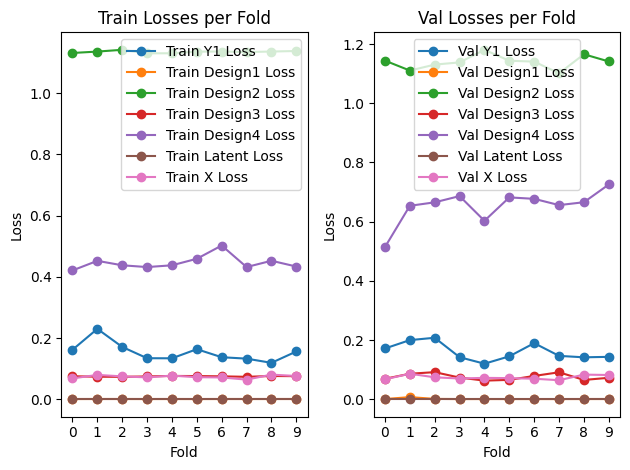

[[1.61650881e-01 7.03737489e-04 1.13176036e+00 7.51748234e-02
  4.21009064e-01 0.00000000e+00 6.81644827e-02]
 [2.30048433e-01 8.27384763e-04 1.13633406e+00 7.36858547e-02
  4.52360988e-01 0.00000000e+00 7.94842392e-02]
 [1.71011120e-01 8.14384373e-04 1.14212036e+00 7.32626468e-02
  4.37835336e-01 0.00000000e+00 7.48156309e-02]
 [1.34109735e-01 7.16671464e-04 1.13060236e+00 7.45741576e-02
  4.32039857e-01 0.00000000e+00 7.14114159e-02]
 [1.33839279e-01 7.98673194e-04 1.13076496e+00 7.62211680e-02
  4.37791735e-01 0.00000000e+00 7.73045719e-02]
 [1.63612440e-01 6.80142373e-04 1.13610172e+00 7.57892653e-02
  4.59104389e-01 0.00000000e+00 7.21171796e-02]
 [1.37375921e-01 7.96582317e-04 1.13650942e+00 7.48801976e-02
  5.02454996e-01 0.00000000e+00 7.12783337e-02]
 [1.32732123e-01 7.81519630e-04 1.13473463e+00 7.32976049e-02
  4.32087481e-01 0.00000000e+00 6.41231611e-02]
 [1.19023360e-01 7.85600278e-04 1.13648772e+00 7.60138109e-02
  4.52627540e-01 0.00000000e+00 8.04741830e-02]
 [1.561115

In [6]:
fig, ax = plt.subplots(1, 2)
folds = np.arange(0, 10, 1)
all_train_pred_losses = np.array([ind_losses_dict_train[f'seed_{fold}'] for fold in folds])
all_val_pred_losses = np.array([ind_losses_dict_val[f'seed_{fold}'] for fold in folds])
ax[0].plot(folds, all_train_pred_losses[:, 0].squeeze(), label='Train Y1 Loss', marker='o', linestyle='-')
ax[0].plot(folds, all_train_pred_losses[:, 1], label='Train Design1 Loss', marker='o', linestyle='-')
# ax[0].plot(folds, all_train_pred_losses[:, 3], label='Train Desc Loss', marker='o', linestyle='-')
ax[0].plot(folds, all_train_pred_losses[:, 2], label='Train Design2 Loss', marker='o', linestyle='-')
ax[0].plot(folds, all_train_pred_losses[:, 3], label='Train Design3 Loss', marker='o', linestyle='-')
ax[0].plot(folds, all_train_pred_losses[:, 4], label='Train Design4 Loss', marker='o', linestyle='-')
ax[0].plot(folds, all_train_pred_losses[:, 5], label='Train Latent Loss', marker='o', linestyle='-')
ax[0].plot(folds, all_train_pred_losses[:, 6], label='Train X Loss', marker='o', linestyle='-')
ax[0].set_xlabel('Fold')
ax[0].set_ylabel('Loss')
ax[0].set_title('Train Losses per Fold')
ax[0].legend()
ax[0].set_xticks(folds)
ax[1].plot(folds, all_val_pred_losses[:, 0], label='Val Y1 Loss', marker='o', linestyle='-')
ax[1].plot(folds, all_val_pred_losses[:, 1], label='Val Design1 Loss', marker='o', linestyle='-')
# ax[1].plot(folds, all_val_pred_losses[:, 2], label='Val Latent Loss', marker='o', linestyle='-')
# ax[1].plot(folds, all_val_pred_losses[:, 3], label='Val Desc Loss', marker='o', linestyle='-')
ax[1].plot(folds, all_val_pred_losses[:, 2], label='Val Design2 Loss', marker='o', linestyle='-')
ax[1].plot(folds, all_val_pred_losses[:, 3], label='Val Design3 Loss', marker='o', linestyle='-')
ax[1].plot(folds, all_val_pred_losses[:, 4], label='Val Design4 Loss', marker='o', linestyle='-')
ax[1].plot(folds, all_val_pred_losses[:, 5], label='Val Latent Loss', marker='o', linestyle='-')
ax[1].plot(folds, all_val_pred_losses[:, 6], label='Val X Loss', marker='o', linestyle='-')
ax[1].set_xlabel('Fold')
ax[1].set_ylabel('Loss')
ax[1].set_title('Val Losses per Fold')
ax[1].legend()
ax[1].set_xticks(folds)     
plt.tight_layout()
plt.show()

print(all_train_pred_losses)
print('\n')
print(all_val_pred_losses)

print(np.sum(all_val_pred_losses, axis=1))
print(np.argmin(np.sum(all_val_pred_losses, axis=1)))
# ax[0].plot(folds, ind)

### Load the selected trained AE

In [ ]:
class Arctanh(torch.nn.Module):
    def forward(self, x):
        return torch.atanh(torch.clamp(x, -0.999999, 0.999999))
    
atanh_act_fn = Arctanh()

latent_dim = 12
fold_num = 3
loaded_state_dict = f'runs/nestedae_ae1_conditioned_perov_STHE/fold{fold_num}_{latent_dim}D'
module_params = {'name':'AE1', 
                    'modules':{
                        
                        # AE1 encoder = AE2 encoder archiecture
                        'encoder':{
                            'input_dim':19,
                            'output_dim':latent_dim,
                            'hidden_dim':25,
                            'hidden_layers':1, 
                            'hidden_activation':None, 
                            'output_activation':torch.nn.Tanh(), 
                            'layer_kernel_init':'xavier_normal', 
                            'layer_bias_init':'zeros', 
                            },

                        'STHE_predictor':{
                            'input_dim':latent_dim,
                            'output_dim':1,
                            'hidden_dim':25,
                            'hidden_layers':1,
                            'hidden_activation':torch.nn.ReLU(),
                            'output_activation':torch.nn.ReLU(),
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros'},

                        'A_predictor':{
                            'input_dim':latent_dim,
                            'output_dim':4,
                            'hidden_dim':25,
                            'hidden_layers':1,
                            'hidden_activation':torch.nn.ReLU(),
                            'output_activation':None,
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros'},

                        'B_predictor':{
                            'input_dim':latent_dim,
                            'output_dim':6,
                            'hidden_dim':25,
                            'hidden_layers':1,
                            'hidden_activation':torch.nn.ReLU(),
                            'output_activation':None,
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros'},

                        'X_predictor':{
                            'input_dim':latent_dim,
                            'output_dim':3,
                            'hidden_dim':25,
                            'hidden_layers':1,
                            'hidden_activation':torch.nn.ReLU(),
                            'output_activation':None,
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros'},   

                        'decoder':{
                            'input_dim':latent_dim,
                            'output_dim':19,
                            'hidden_dim':25,
                            'hidden_layers':1,
                            'hidden_activation':torch.nn.ReLU(),
                            'output_activation':None,
                            'layer_kernel_init':'xavier_normal',
                            'layer_bias_init':'zeros'}

                    }}

loaded_ae = NestedAE(module_params)
loaded_ae.load_state_dict(torch.load(loaded_state_dict))
loaded_ae.eval()

### Get latents for next dataset

In [ ]:
print(np.array(desc_means).reshape(-1, 1), np.array(desc_std_devs).reshape(-1, 1))

x_df = pd.read_csv('datasets/MHP_for_water_splitting/dataset.csv')[descriptors]

for i, desc in enumerate(x_df.columns.tolist()):
    x_df[desc] = (x_df[desc] - desc_means[i]) / desc_std_devs[i]

x_torch = torch.from_numpy(x_df.to_numpy(dtype=np.float32)).to(dtype=torch.float32)
with torch.no_grad():
    ae_out = loaded_ae(x_torch)
latents = ae_out['z']
sthe_pred = ae_out['y1_pred']
a_design_pred = torch.argmax(torch.softmax(ae_out['design1_pred'], dim=1), dim=1) # No mixing at A site
b_design_pred = torch.softmax(ae_out['design2_pred'], dim=1)
x_design_pred = torch.softmax(ae_out['design3_pred'], dim=1)
np.savetxt('datasets/MHP_for_water_splitting/nestedae_cond_ae1_preds/a_design_pred.csv', a_design_pred.detach().numpy(), delimiter=",")
np.savetxt('datasets/MHP_for_water_splitting/nestedae_cond_ae1_preds/b_design_pred.csv', b_design_pred.detach().numpy(), delimiter=",")
np.savetxt('datasets/MHP_for_water_splitting/nestedae_cond_ae1_preds/x_design_pred.csv', x_design_pred.detach().numpy(), delimiter=",")
np.savetxt('datasets/MHP_for_water_splitting/nestedae_cond_ae1_preds/sthe_pred.csv', sthe_pred.detach().numpy(), delimiter=",")
np.savetxt('datasets/MHP_for_water_splitting/nestedae_cond_ae1_preds/latents_pred.csv', latents.detach().numpy(), delimiter=",")

#### Plot model training results

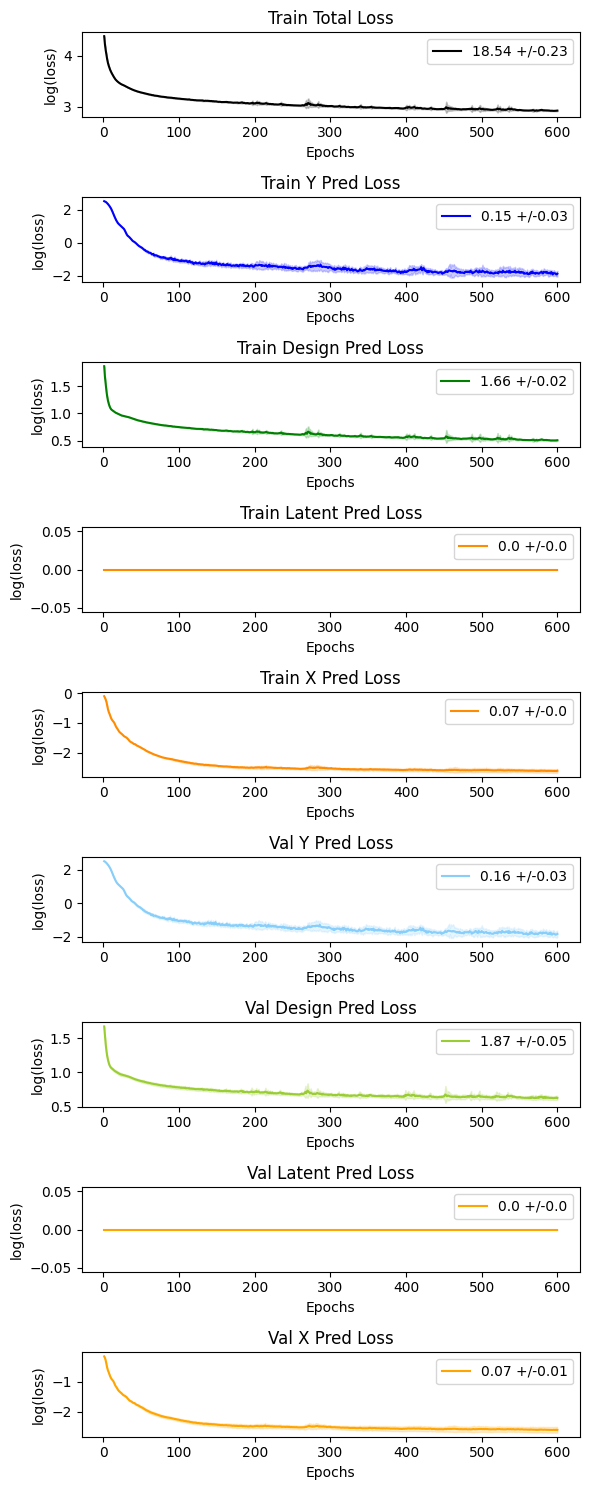

In [7]:
num_latents = len(latent_col_names)
epochs = np.arange(1, num_epochs + 1)
# Plot mean and standard deviation of losses
train_mean_total_pred_loss = np.mean(np.log(np.array(train_total_pred_loss_per_epoch_per_seed)), axis=0)
train_std_total_pred_loss = np.std(np.log(np.array(train_total_pred_loss_per_epoch_per_seed)), axis=0)

train_mean_design_pred_loss = np.mean(np.log(np.array(train_design_pred_loss_per_epoch_per_seed)), axis=0) 
train_std_design_pred_loss = np.std(np.log(np.array(train_design_pred_loss_per_epoch_per_seed)), axis=0)

train_mean_x_pred_loss = np.mean(np.log(np.array(train_x_pred_loss_per_epoch_per_seed)), axis=0)
train_std_x_pred_loss = np.std(np.log(np.array(train_x_pred_loss_per_epoch_per_seed)), axis=0)

if len(latent_col_names) > 0:
      train_mean_latent_pred_loss = np.mean(np.log(np.array(train_latent_pred_loss_per_epoch_per_seed)), axis=0)
      train_std_latent_pred_loss = np.std(np.log(np.array(train_latent_pred_loss_per_epoch_per_seed)), axis=0)
else:
      train_mean_latent_pred_loss = np.mean(train_latent_pred_loss_per_epoch_per_seed, axis=0)
      train_std_latent_pred_loss = np.std(train_latent_pred_loss_per_epoch_per_seed, axis=0)

if len(target) > 0:
      train_mean_y_pred_loss = np.mean(np.log(np.array(train_y_pred_loss_per_epoch_per_seed)), axis=0)
      train_std_y_pred_loss = np.std(np.log(np.array(train_y_pred_loss_per_epoch_per_seed)), axis=0)
else:
      train_mean_y_pred_loss = np.mean(train_y_pred_loss_per_epoch_per_seed, axis=0)
      train_std_y_pred_loss = np.std(train_y_pred_loss_per_epoch_per_seed, axis=0)

val_mean_design_pred_loss = np.mean(np.log(np.array(val_design_pred_loss_per_epoch_per_seed)), axis=0)
val_std_design_pred_loss = np.std(np.log(np.array(val_design_pred_loss_per_epoch_per_seed)), axis=0)

val_mean_x_pred_loss = np.mean(np.log(np.array(val_x_pred_loss_per_epoch_per_seed)), axis=0)
val_std_x_pred_loss = np.std(np.log(np.array(val_x_pred_loss_per_epoch_per_seed)), axis=0)

if len(latent_col_names) > 0:
      val_mean_latent_pred_loss = np.mean(np.log(np.array(val_latent_pred_loss_per_epoch_per_seed)), axis=0)
      val_std_latent_pred_loss = np.std(np.log(np.array(val_latent_pred_loss_per_epoch_per_seed)), axis=0)
else:
      val_mean_latent_pred_loss = np.mean(val_latent_pred_loss_per_epoch_per_seed, axis=0)
      val_std_latent_pred_loss = np.std(val_latent_pred_loss_per_epoch_per_seed, axis=0)

if len(target) > 0:
      val_mean_y_pred_loss = np.mean(np.log(np.array(val_y_pred_loss_per_epoch_per_seed)), axis=0)
      val_std_y_pred_loss = np.std(np.log(np.array(val_y_pred_loss_per_epoch_per_seed)), axis=0)
else:
      val_mean_y_pred_loss = np.mean(val_y_pred_loss_per_epoch_per_seed, axis=0)
      val_std_y_pred_loss = np.std(val_y_pred_loss_per_epoch_per_seed, axis=0)

# Plotting
plt.figure(figsize=(6, 15))
plt.subplot(9, 1, 1)
plt.plot(epochs, train_mean_total_pred_loss, 
         label=f'{round(np.mean(np.array(train_total_pred_loss_per_epoch_per_seed)[:, -1]), 2)} +/-' +
               f'{round(np.std(np.array(train_total_pred_loss_per_epoch_per_seed)[:, -1]), 2)}', 
        color='black')
plt.fill_between(epochs, train_mean_total_pred_loss - train_std_total_pred_loss, 
                 train_mean_total_pred_loss + train_std_total_pred_loss, color='black', alpha=0.2)
plt.title('Train Total Loss')
plt.xlabel('Epochs')
plt.ylabel('log(loss)')
plt.legend()

plt.subplot(9, 1, 2)
plt.plot(epochs, train_mean_y_pred_loss, 
         label=f'{round(np.mean(np.array(train_y_pred_loss_per_epoch_per_seed)[:, -1]), 2)} +/-' +
               f'{round(np.std(np.array(train_y_pred_loss_per_epoch_per_seed)[:, -1]), 2)}', 
         color='blue')
plt.fill_between(epochs, train_mean_y_pred_loss - train_std_y_pred_loss,
                train_mean_y_pred_loss + train_std_y_pred_loss, color='blue', alpha=0.2)
plt.title('Train Y Pred Loss')
plt.xlabel('Epochs')
plt.ylabel('log(loss)')
plt.legend()

plt.subplot(9, 1, 3)
plt.plot(epochs, train_mean_design_pred_loss, 
         label=f'{round(np.mean(np.array(train_design_pred_loss_per_epoch_per_seed)[:, -1]), 2)} +/-' +
               f'{round(np.std(np.array(train_design_pred_loss_per_epoch_per_seed)[:, -1]), 2)}', 
         color='green')
plt.fill_between(epochs, train_mean_design_pred_loss - train_std_design_pred_loss,
                 train_mean_design_pred_loss + train_std_design_pred_loss, color='green', alpha=0.2)
plt.title('Train Design Pred Loss')
plt.xlabel('Epochs')
plt.ylabel('log(loss)')
plt.legend()

plt.subplot(9, 1, 4)
plt.plot(epochs, train_mean_latent_pred_loss, 
         label=f'{round(np.mean(np.array(train_latent_pred_loss_per_epoch_per_seed)[:, -1]), 2)} +/-' +
               f'{round(np.std(np.array(train_latent_pred_loss_per_epoch_per_seed)[:, -1]), 2)}', 
         color='darkorange')
plt.fill_between(epochs, train_mean_latent_pred_loss - train_std_latent_pred_loss,
                  train_mean_latent_pred_loss + train_std_latent_pred_loss, color='darkorange', alpha=0.2)
plt.title('Train Latent Pred Loss')
plt.xlabel('Epochs')
plt.ylabel('log(loss)')
plt.legend()

plt.subplot(9, 1, 5)
plt.plot(epochs, train_mean_x_pred_loss, 
         label=f'{round(np.mean(np.array(train_x_pred_loss_per_epoch_per_seed)[:, -1]), 2)} +/-' +
               f'{round(np.std(np.array(train_x_pred_loss_per_epoch_per_seed)[:, -1]), 2)}', 
         color='darkorange')
plt.fill_between(epochs, train_mean_x_pred_loss - train_std_x_pred_loss,
                  train_mean_x_pred_loss + train_std_x_pred_loss, color='darkorange', alpha=0.2)
plt.title('Train X Pred Loss')
plt.xlabel('Epochs')
plt.ylabel('log(loss)')
plt.legend()

plt.subplot(9, 1, 6)
plt.plot(epochs, val_mean_y_pred_loss,
         label=f'{round(np.mean(np.array(val_y_pred_loss_per_epoch_per_seed)[:, -1]), 2)} +/-' +
               f'{round(np.std(np.array(val_y_pred_loss_per_epoch_per_seed)[:, -1]), 2)}', color='lightskyblue')
plt.fill_between(epochs, val_mean_y_pred_loss - val_std_y_pred_loss,
                  val_mean_y_pred_loss + val_std_y_pred_loss, color='lightskyblue', alpha=0.2)
plt.title('Val Y Pred Loss')
plt.xlabel('Epochs')
plt.ylabel('log(loss)')
plt.legend()

plt.subplot(9, 1, 7)
plt.plot(epochs, val_mean_design_pred_loss, 
         label=f'{round(np.mean(np.array(val_design_pred_loss_per_epoch_per_seed)[:, -1]), 2)} +/-' +
               f'{round(np.std(np.array(val_design_pred_loss_per_epoch_per_seed)[:, -1]), 2)}', color='yellowgreen')
plt.fill_between(epochs, val_mean_design_pred_loss - val_std_design_pred_loss, 
                 val_mean_design_pred_loss + val_std_design_pred_loss, color='yellowgreen', alpha=0.2)
plt.title('Val Design Pred Loss')
plt.xlabel('Epochs')
plt.ylabel('log(loss)')
plt.legend()

plt.subplot(9, 1, 8)
plt.plot(epochs, val_mean_latent_pred_loss, 
      label=f'{round(np.mean(np.array(val_latent_pred_loss_per_epoch_per_seed)[:, -1]), 2)} +/-'+
            f'{round(np.std(np.array(val_latent_pred_loss_per_epoch_per_seed)[:, -1]), 2)}', color='orange')
plt.fill_between(epochs, val_mean_latent_pred_loss - val_std_latent_pred_loss, 
                 val_mean_latent_pred_loss + val_std_latent_pred_loss, color='orange', alpha=0.2)
plt.title('Val Latent Pred Loss')
plt.xlabel('Epochs')
plt.ylabel('log(loss)')
plt.legend()

plt.subplot(9, 1, 9)
plt.plot(epochs, val_mean_x_pred_loss, 
         label=f'{round(np.mean(np.array(val_x_pred_loss_per_epoch_per_seed)[:, -1]), 2)} +/-'+
               f'{round(np.std(np.array(val_x_pred_loss_per_epoch_per_seed)[:, -1]), 2)}', color='orange')
plt.fill_between(epochs, val_mean_x_pred_loss - val_std_x_pred_loss, 
                 val_mean_x_pred_loss + val_std_x_pred_loss, color='orange', alpha=0.2)
plt.title('Val X Pred Loss')
plt.xlabel('Epochs')
plt.ylabel('log(loss)')
plt.legend()

plt.tight_layout()